I realised just before releasing version 0.0.22 onto PyPi that signal.iirnotch had some weird boundary effects. Even when  I used a pure CF tone and tried to filter out the peak frequency, there were large-sh peaks on either end of  the post-filtered CF-tone. And this too even when the tone was zero-padded. I then realised this weird behaviour might have to do with the fact that I'm using an IIR filter rather than an FIR filter. Here's an attempt to compare  and try to fix this problem. 

In [1]:
import datetime as dt
import matplotlib.pyplot as plt 
import numpy as  np 
import scipy.signal as signal 

In [2]:
print(dt.datetime.now())

2020-02-16 09:05:28.244479


In [3]:
%matplotlib notebook

In [4]:
# create a pure tone CF 
fs = 250000
peak_freq = 100000.0
durn = 0.05 
t = np.linspace(0,durn, int(durn*fs))
cf_tone = np.sin(2*np.pi*peak_freq*t)
cf_tone *= signal.tukey(cf_tone.size, 0.2)
gap = int(0.001*fs)
noise = np.random.normal(0,10**(-60/20),t.size+gap)

tone_w_noise = noise.copy()
tone_w_noise[125:-125] += cf_tone

In [5]:
# first do the iir notch filtering to 
b,a = signal.iirnotch(peak_freq/(fs*0.5),1)


<IPython.core.display.Javascript object>


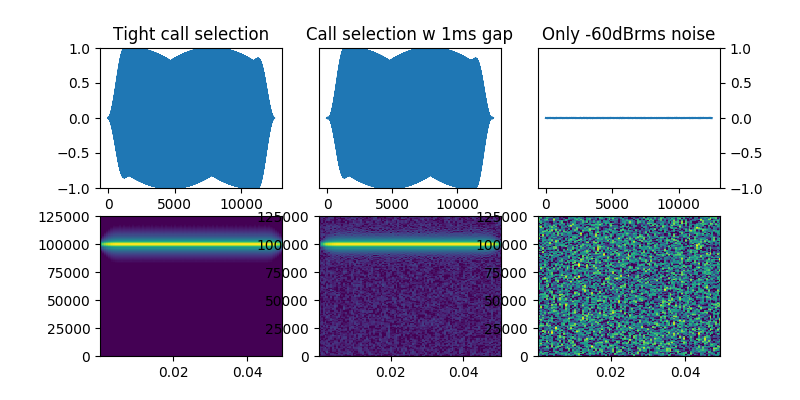

In [6]:
# the raw signal + signal with some noise and gap on L&R side :
ylims = lambda X: plt.ylim(-1, 1)
dyn_range = 20*np.log10(np.max(abs(cf_tone))) - 120

plt.figure(figsize=(8,4))
plt.subplot(231)
plt.plot(cf_tone)
ylims(0)
plt.title('Tight call selection')
plt.subplot(232)
plt.plot(tone_w_noise)
ylims(0);plt.yticks([])
plt.title('Call selection w 1ms gap')
a2 = plt.subplot(233)
just_noise = np.random.normal(0,10**(-60/20), int(fs*durn))
filtered_noise = signal.lfilter(b,a, just_noise)
plt.plot(filtered_noise)
ylims(0)
a2.yaxis.tick_right()
plt.title('Only -60dBrms noise')
plt.subplot(234)
plt.specgram(cf_tone, Fs=fs, vmin=dyn_range);
plt.subplot(235)
plt.specgram(tone_w_noise, Fs=fs, vmin=dyn_range);
plt.subplot(236)
plt.specgram(just_noise, Fs=fs, vmin=dyn_range);

In [7]:
iir_filtered = {}
iir_filtered['only_tone'] = signal.lfilter(b,a, cf_tone)
iir_filtered['tone_w_gap'] = signal.lfilter(b,a, tone_w_noise)

<IPython.core.display.Javascript object>


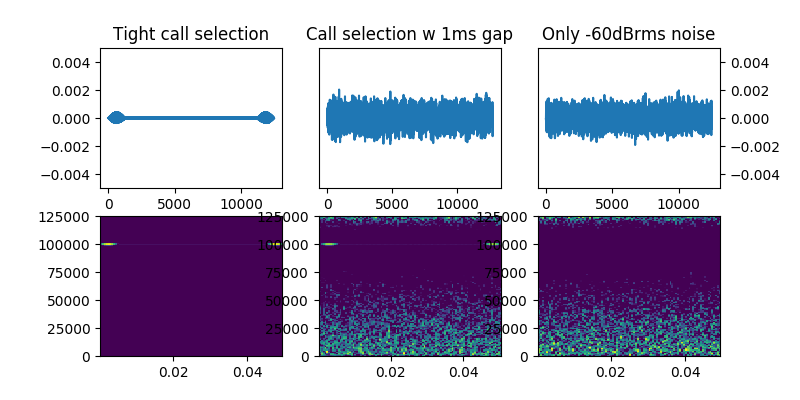

In [8]:
ylims = lambda X: plt.ylim(-0.005, 0.005)

plt.figure(figsize=(8,4))
plt.subplot(231)
plt.plot(iir_filtered['only_tone'])
ylims(0)
plt.title('Tight call selection')
plt.subplot(232)
plt.plot(iir_filtered['tone_w_gap'])
ylims(0);plt.yticks([])
plt.title('Call selection w 1ms gap')
a2 = plt.subplot(233)
just_noise = np.random.normal(0,10**(-60/20), int(fs*durn))
filtered_noise = signal.lfilter(b,a, just_noise)
plt.plot(filtered_noise)
ylims(0)
a2.yaxis.tick_right()
plt.title('Only -60dBrms noise')
plt.subplot(234)
plt.specgram(iir_filtered['only_tone'], Fs=fs, vmin=dyn_range);
plt.subplot(235)
plt.specgram(iir_filtered['tone_w_gap'], Fs=fs, vmin=dyn_range);
plt.subplot(236)
plt.specgram(filtered_noise, Fs=fs, vmin=dyn_range);

### Is there a problem ? 
As I see it now, the problem is really only that when the call selection is very tight, then there  can be false positive FM detection. In principle, this is not great as it can be hard to say when a single non-overlapped call is found. What is the behaviour of an *FIR* filter. Is it more 'normal'. By  normal I basically mean that even with very tight call selections this weird false positive shouldn't appear. 

<IPython.core.display.Javascript object>


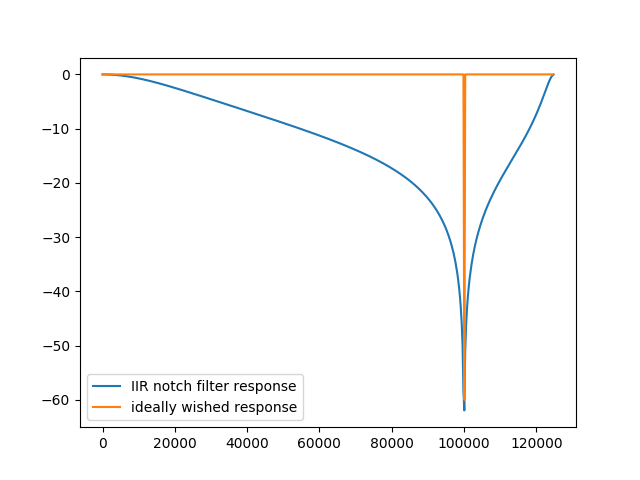

In [9]:
# get frequency response of standard IIR  filter 
f, h = signal.freqz(b,a, fs=fs)
# what the filter should ideally look like:
h_ideal = np.zeros(h.size)
h_ideal[np.argmin(abs(f-peak_freq))] = -60
plt.figure()
plt.plot(f, 20*np.log10(abs(h)),label='IIR notch filter response')
plt.plot(f,h_ideal,label='ideally wished response')
plt.legend()

### What about *amplifying* the peak frequency AND *notch-filtering* the peak frequency:


In [10]:
print('Last cell run at', dt.datetime.now())

Last cell run at 2020-02-16 09:05:29.382642
